# Task 2. Segmenation

In this task, you will implement a segmentation algorithm. 

The dataset for this task is the Oxford Pets dataset (https://www.robots.ox.ac.uk/~vgg/data/pets/). The dataset contains images of cats and dogs, along with their corresponding segmentation masks.
We simplify the masks to binary masks, where the foreground is the animal and the background is everything else; we ignore the border class. 
The dataset is split into a training set and a test set. The training set contains ~ 3,700 images, while the test set contains 3,000 images.

Use U-Net to perform binary semantic segmentation.
1. (**0.5p -- 2p**) Implement U-Net (https://arxiv.org/abs/1505.04597) using PyTorch. You may use padded convolutions to avoid losing border pixels. Consider adding batch normalization.
2. (**1p**) Use Binary Cross Entropy to train the model and visualize predictions. Ignore the border class during loss computation.
3. (**1p**) Implement and calculate pixel accuracy, IoU and Dice coefficient.
4. (**1p**) Try different ways to deal with varied input sizes (resize, crop to smaller size, add padding). Then, pick a few images from the test set and perform inference on them while keeping their original size. Compare the results.
5. (**0.5p**) Perform an ablation study on residual connections in the U-Net architecture.



## Installation

In [ ]:
!pip install segmentation_models_pytorch -q
!pip install wandb -qU

## Some useful code

In [2]:
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import wandb

from typing import Optional

from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import wrap_dataset_for_transforms_v2, OxfordIIITPet
from torchvision.tv_tensors import Mask
from tqdm.auto import tqdm
import numpy as np

In [3]:
wandb.login();

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: fejowo5522 (fejowo5522-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
class SegmentationDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, transform, length=None):
        self.dataset = dataset
        self.length = len(dataset)
        self.transform = transform

    def __getitem__(self, index):
        image, mask = self.dataset[index]
        return self.transform(image, mask)

    def __len__(self):
        return self.length
    
def create_wrapped_dataset(dataset, transform):
    wrapped_dataset = wrap_dataset_for_transforms_v2(dataset)
    return SegmentationDatasetWrapper(wrapped_dataset, transform=transform)

# HERE: Set up the size of the images
IMG_SIZE = (128, 128)

transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
target_transform = lambda mask: Mask(2 - mask.squeeze(0))

train_ds_orig = OxfordIIITPet(root=".", target_types="segmentation", download=True, transform=transform, target_transform=target_transform)
train_ds = create_wrapped_dataset(train_ds_orig, transform=v2.Resize(size=IMG_SIZE, antialias=True))

test_ds_orig = OxfordIIITPet(root=".", split="test", target_types="segmentation", download=True, transform=transform, target_transform=target_transform)
test_ds = create_wrapped_dataset(test_ds_orig, transform=v2.Resize(size=IMG_SIZE, antialias=True))

100%|██████████| 792M/792M [22:01<00:00, 599kB/s]    


Extracting oxford-iiit-pet\images.tar.gz to oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:45<00:00, 424kB/s] 


Extracting oxford-iiit-pet\annotations.tar.gz to oxford-iiit-pet


### Plot original image and mask

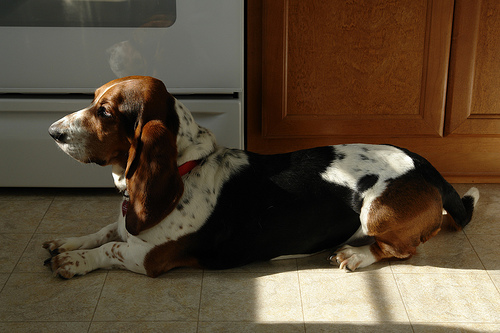

In [ ]:
# Plot sample image
image_orig, mask_orig = train_ds_orig[2025]
image_orig

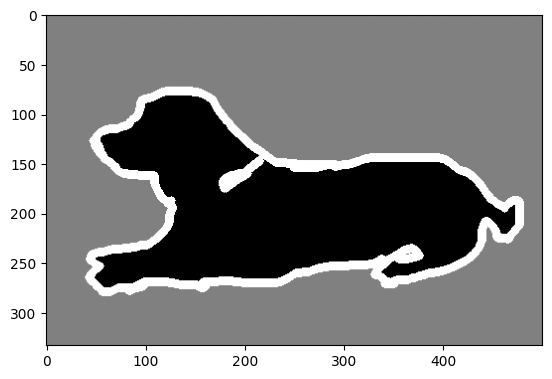

In [ ]:
mask_np = np.array(mask_orig)
plt.imshow(mask_np, cmap="gray")
plt.show()

### Plot resized image and mask

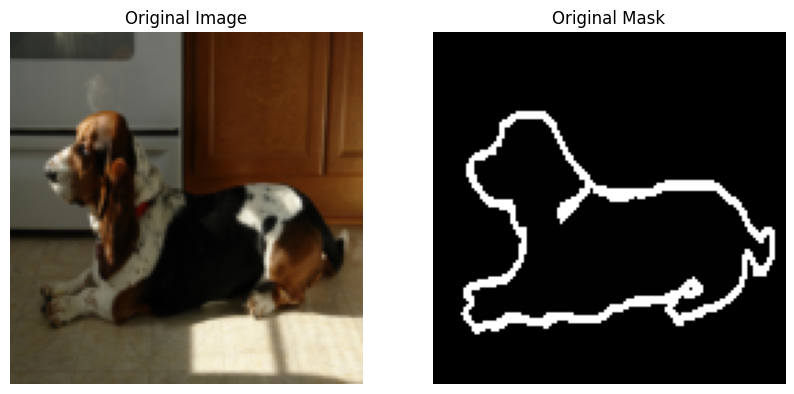

In [ ]:
image, mask = train_ds[2025]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(0), cmap="gray")
plt.title("Original Mask")
plt.axis("off")
plt.show()

### Masks

Observe, that we modify the masks (1: foreground, 2: background, 3: border) to be (0: background, 1: foreground, 255: border).

Later we will ignore the border class during loss computation. 

In [ ]:
mask.unique()  # tensor([0, 1], dtype=torch.uint8)

tensor([  0,   1, 255], dtype=torch.uint8)

In [5]:
# TASK 1.3:
def iou(gt, pred, ignore_index=255, eps=1e-8):
    pred[gt == ignore_index] = 0
    gt[gt == ignore_index] = 0

    intersection = (gt & pred).sum(dim=1).float()
    union = (gt | pred).sum(dim=1).float()
    iou = intersection / (union + eps) # implement intersection over union (IoU), we ignore the ignore_index (255=border)

    return iou

def dice(gt, pred, ignore_index=255, eps=1e-8):
    pred[gt == ignore_index] = 0
    gt[gt == ignore_index] = 0

    intersection = (gt & pred).sum(dim=1).float()
    cardinality = gt.sum(dim=1).float() + pred.sum(dim=1).float()
    dice = 2 * intersection / (cardinality + eps) # implement dice score, we ignore the ignore_index (255=border)

    return dice

def accuracy(gt, pred, ignore_index=255):
    pred[gt == ignore_index] = 0
    gt[gt == ignore_index] = 0

    correct = (gt == pred).sum(dim=1).float()
    total = gt.numel() // gt.shape[0]
    acc = correct / total # implement accuracy, we ignore the ignore_index (255=border)

    return acc

def eval(model, dataloader):
    model.eval()

    metrics = {
        "loss": 0,
        "iou": 0,
        "dice": 0,
        "accuracy": 0,
    }

    ds_len = 0

    for batch in dataloader:
        images, masks = batch
        images = images.cuda()
        masks = masks.cuda()

        ds_len += images.shape[0]
        with torch.no_grad():
            loss, logits = model(images, masks)
            labels = torch.flatten(torch.sigmoid(logits) > 0.5, 1)
            gt = torch.flatten(masks, 1)

            metrics["loss"] += loss.sum().item()
            metrics["iou"] += iou(gt, labels).sum().item()
            metrics["dice"] += dice(gt, labels).sum().item()
            metrics["accuracy"] += accuracy(gt, labels).sum().item()

    for metric in metrics:
        metrics[metric] /= ds_len

    return metrics

## Model

In [ ]:
# TASK 1:
# Implement a UNet model
# (2p) implement a UNet model in pure pytorch
# (0.5p) implement a UNet model using segmentation_models_pytorch package
#        (see https://github.com/qubvel-org/segmentation_models.pytorch?tab=readme-ov-file#1-create-your-first-segmentation-model-with-smp), 
#        remember to use encoder_weights=None 
# Hint:
# - 'resnet18' as the encoder backbone could be a good choice for faster training
# - 'resnet34' as the encoder backbone could be a good choice for better accuracy

class UNet(nn.Module):
    def __init__(self, ignore_index=255):
        super(UNet, self).__init__()
        
        # TODO: implement a UNet model here

        self.ignore_index = ignore_index

    def forward(
        self,
        pixel_values: torch.FloatTensor,
        labels: Optional[torch.LongTensor] = None,
    ):
        logits = self.unet(pixel_values)

        loss = None
        if labels is not None:
            loss = _ # TODO: implement the loss function; Hint: use BCEWithLogitsLoss(reduction="none")
        return loss, logits

In [6]:
model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

### Create dataloaders

One can experiment with different batch sizes.

In [7]:
train_dataloder = DataLoader(train_ds, batch_size=16, shuffle=True)
test_dataloder = DataLoader(test_ds, batch_size=16, shuffle=False)

## Training

Below is the training loop and some partial results from W&B tracking.
The project is not shared.

In [ ]:
ignore_index = 255

config = {
    "learning_rate": 1e-4,
    "epochs": 3,
    "img_size": IMG_SIZE,
    # TODO: add other hyperparameters here (e.g. batch size, model architecture, etc.)
}

run = wandb.init(
    project="List4",
    config=config,
)

unet = UNet(ignore_index=ignore_index).cuda()
optimizer = torch.optim.Adam(unet.parameters(), lr=config["learning_rate"])

for epoch_idx in tqdm(range(config["epochs"]), desc="epoch"):
    unet.train()
    for batch in tqdm(train_dataloder, desc="batch"):
        optimizer.zero_grad()

        images, masks = batch
        images = images.cuda()
        masks = masks.cuda()

        loss, logits = unet(images.cuda(), masks.cuda())
        loss = loss.mean()
        loss.backward()
        optimizer.step()

        labels = torch.flatten(torch.sigmoid(logits) > 0.5, 1)
        gt = torch.flatten(masks, 1)

        run.log({
            "epoch": epoch_idx,
            "train/loss": loss.item(),
            "train/iou": iou(gt, labels).mean(),
            "train/dice": dice(gt, labels).mean(),
            "train/accuracy": accuracy(gt, labels).mean(),
            })

    metrics = eval(unet, test_dataloder)
    for metric, value in metrics.items():
        run.log({f"eval/{metric}": value})
run.finish()

epoch: 100%|██████████| 3/3 [04:52<00:00, 97.56s/it]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅███████████
eval/accuracy,▁▃█
eval/dice,▁▄█
eval/iou,▁▅█
eval/loss,█▅▁
train/accuracy,▁▁▃▃▃▄▅▅▆▅▆▆▆▇▆▆▆▇▆▅▅▇▆▇▆▆▆▇█▇▇▇▇▇▇▇▅▇▇▇
train/dice,▁▂▅▄▅▅▅▄▆▅▆▆▅▄▆▆▇▇▆▆▇▆▆▇▇▇▇▇▇▆▇██▆▇▇██▇▆
train/iou,▁▃▅▅▅▆▅▅▆▅▅▆▅▆▆▇▆▆▆▇▅▆▅▆▆█▆▇▇▇▇▇▆█▇▇▆▇▇▇
train/loss,█▇▅▄▅▃▃▃▃▃▃▂▂▂▂▂▃▁▂▂▂▂▂▂▂▃▃▂▂▂▂▁▂▂▂▁▃▁▁▂
epoch,2
eval/accuracy,0.9109


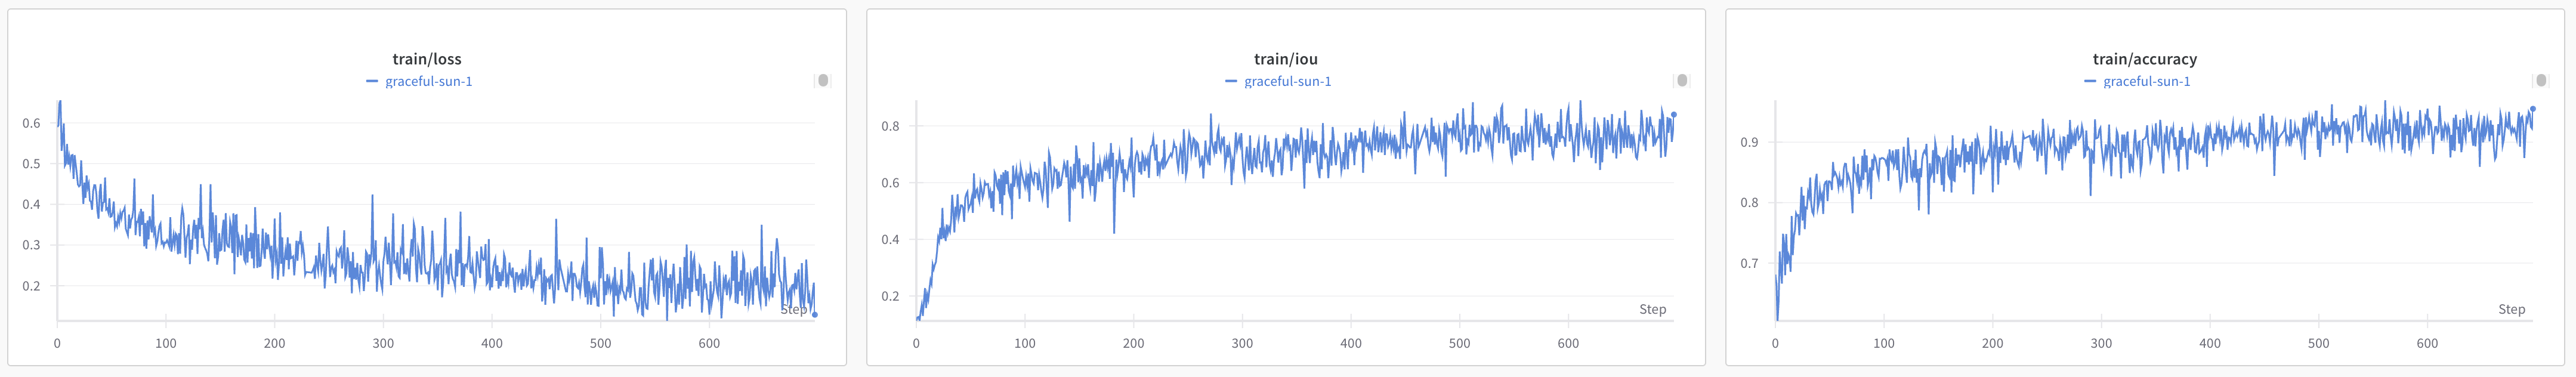

In [ ]:
unet

### Task 2.4

### Task 2.5